## Enflasyon tahmini

## Yönlendirme
I. <b>Import Libraries and Data Loading</b><br>
a) [Import Libraries and Data Loading](#libraries)<br><br>

II. <b> Data Understanding</b><br>
a) [Macroeconomic Trends](#trend)<br>
b) [Core CPI trend by Month and Quarter](#mq)<br><br>

III. <b> Forecast</b><br>
a) [ARIMA](#arima)<br>
b) [Univariate Forecasting with LSTM](#ulstm)<br>
c) [Multivariate Forecasting with LSTM](#mlstm)<br>


##  Import Libraries and Data Loading
<a id="libraries"></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import numpy as np

def mean_squared_error(y_true, y_pred):
    """
    Gerçek değerler (y_true) ile tahmin edilen değerler (y_pred) arasındaki
    ortalama kare hata (Mean Squared Error) hesaplar.
    
    Args:
    y_true (array-like): Gerçek değerler
    y_pred (array-like): Tahmin edilen değerler
    
    Returns:
    float: Ortalama kare hata (MSE)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

np.random.seed(234)
tf.random.set_seed(234)

In [2]:
print(tf.__version__)

2.10.0


In [3]:
monthly_raw = pd.read_csv('C:/Users/cetin/Desktop/macro_monthly1.csv',parse_dates=True)
monthly_raw.shape
monthly_raw.head()

(524, 12)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,1981-01-01,7.5,10.9,1612.900,4980.4,1870.0,NaN,12.568571,19.084516,NaN,51.1668,85.4
1,1981-02-01,7.4,10.8,1608.125,4965.0,1884.2,NaN,13.194444,15.934286,NaN,50.9509,85.9
2,1981-03-01,7.4,10.8,1629.400,4979.0,1902.9,NaN,13.115909,14.703871,NaN,51.2066,86.4
3,1981-04-01,7.2,10.9,1665.575,4965.1,1904.4,NaN,13.679524,15.719000,NaN,50.9711,87.0
4,1981-05-01,7.5,11.0,1655.150,4974.8,1913.8,NaN,14.099500,18.517742,NaN,51.2645,87.8


nan değerlerin drop edilip verilen tam olduğu kısım ele alınır

In [4]:
##monthly_raw.dropna(inplace=True)
monthly_raw.fillna(0, inplace=True)
monthly_raw.head(10)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,1981-01-01,7.5,10.9,1612.900,4980.4,1870.0,0.0,12.568571,19.084516,0.0,51.1668,85.4
1,1981-02-01,7.4,10.8,1608.125,4965.0,1884.2,0.0,13.194444,15.934286,0.0,50.9509,85.9
2,1981-03-01,7.4,10.8,1629.400,4979.0,1902.9,0.0,13.115909,14.703871,0.0,51.2066,86.4
3,1981-04-01,7.2,10.9,1665.575,4965.1,1904.4,0.0,13.679524,15.719000,0.0,50.9711,87.0
4,1981-05-01,7.5,11.0,1655.150,4974.8,1913.8,0.0,14.099500,18.517742,0.0,51.2645,87.8
5,1981-06-01,7.5,10.8,1664.500,5001.9,1934.5,0.0,13.472273,19.099667,0.0,51.5247,88.6
6,1981-07-01,7.2,12.3,1685.225,5080.8,1942.1,0.0,14.280909,19.035806,0.0,51.8727,89.8
7,1981-08-01,7.4,12.0,1693.280,5095.9,1966.6,0.0,14.937143,17.817742,0.0,51.8156,90.7
8,1981-09-01,7.6,12.4,1706.150,5087.2,1965.5,0.0,15.323810,15.874000,0.0,51.5692,91.8
9,1981-10-01,7.9,13.0,1725.450,5093.8,1963.9,0.0,15.148095,15.080000,0.0,51.1851,92.1


## Data Understanding
Veri tiplerini hızlı bir şekilde kontrol etme ve gerçek zamanlı başlangıç ​​ve tarihi tarih-zamana dönüştürme.

In [5]:
monthly_raw.dtypes

monthly_raw.DATE = pd.to_datetime(monthly_raw.DATE)

DATE       object
unrate    float64
psr       float64
m2        float64
dspic     float64
pce       float64
reer      float64
ir        float64
ffer      float64
tcs       float64
indpro    float64
ccpi      float64
dtype: object

Veri setindeki ay/yıl sayısını kontrol etme

In [6]:
monthly_raw['DATE'].nunique()

524

kopyasını oluşturma

In [7]:
monthly_df = monthly_raw.copy()

### Macroeconomic Indicator Trend
<a id = "trend"></a>
Öncelikle özellik oluşturma işlemini gerçekleştirip, Ay-Ay ve Yıl-Yıl bazında yüzdelik değişim yaratabiliriz.

array([[<Axes: title={'center': 'Unemployment Rate'}>,
        <Axes: title={'center': 'Personal Saving Rate'}>,
        <Axes: title={'center': 'M2'}>],
       [<Axes: title={'center': 'Disposable Income'}>,
        <Axes: title={'center': 'Personal Consumption Expenditure'}>,
        <Axes: title={'center': 'Real Effective Exchange Rate'}>],
       [<Axes: title={'center': '10Y Treasury Yield'}>,
        <Axes: title={'center': 'Fed Rate'}>,
        <Axes: title={'center': 'Construction Spending'}>],
       [<Axes: title={'center': 'Industrial Production Index'}>,
        <Axes: title={'center': 'Core CPI'}>,
        <Axes: title={'center': 'Core CPI % Change MoM'}>]], dtype=object)

Text(0.5, 0.98, '43 Year Macroeconomic Indicators for the United States')

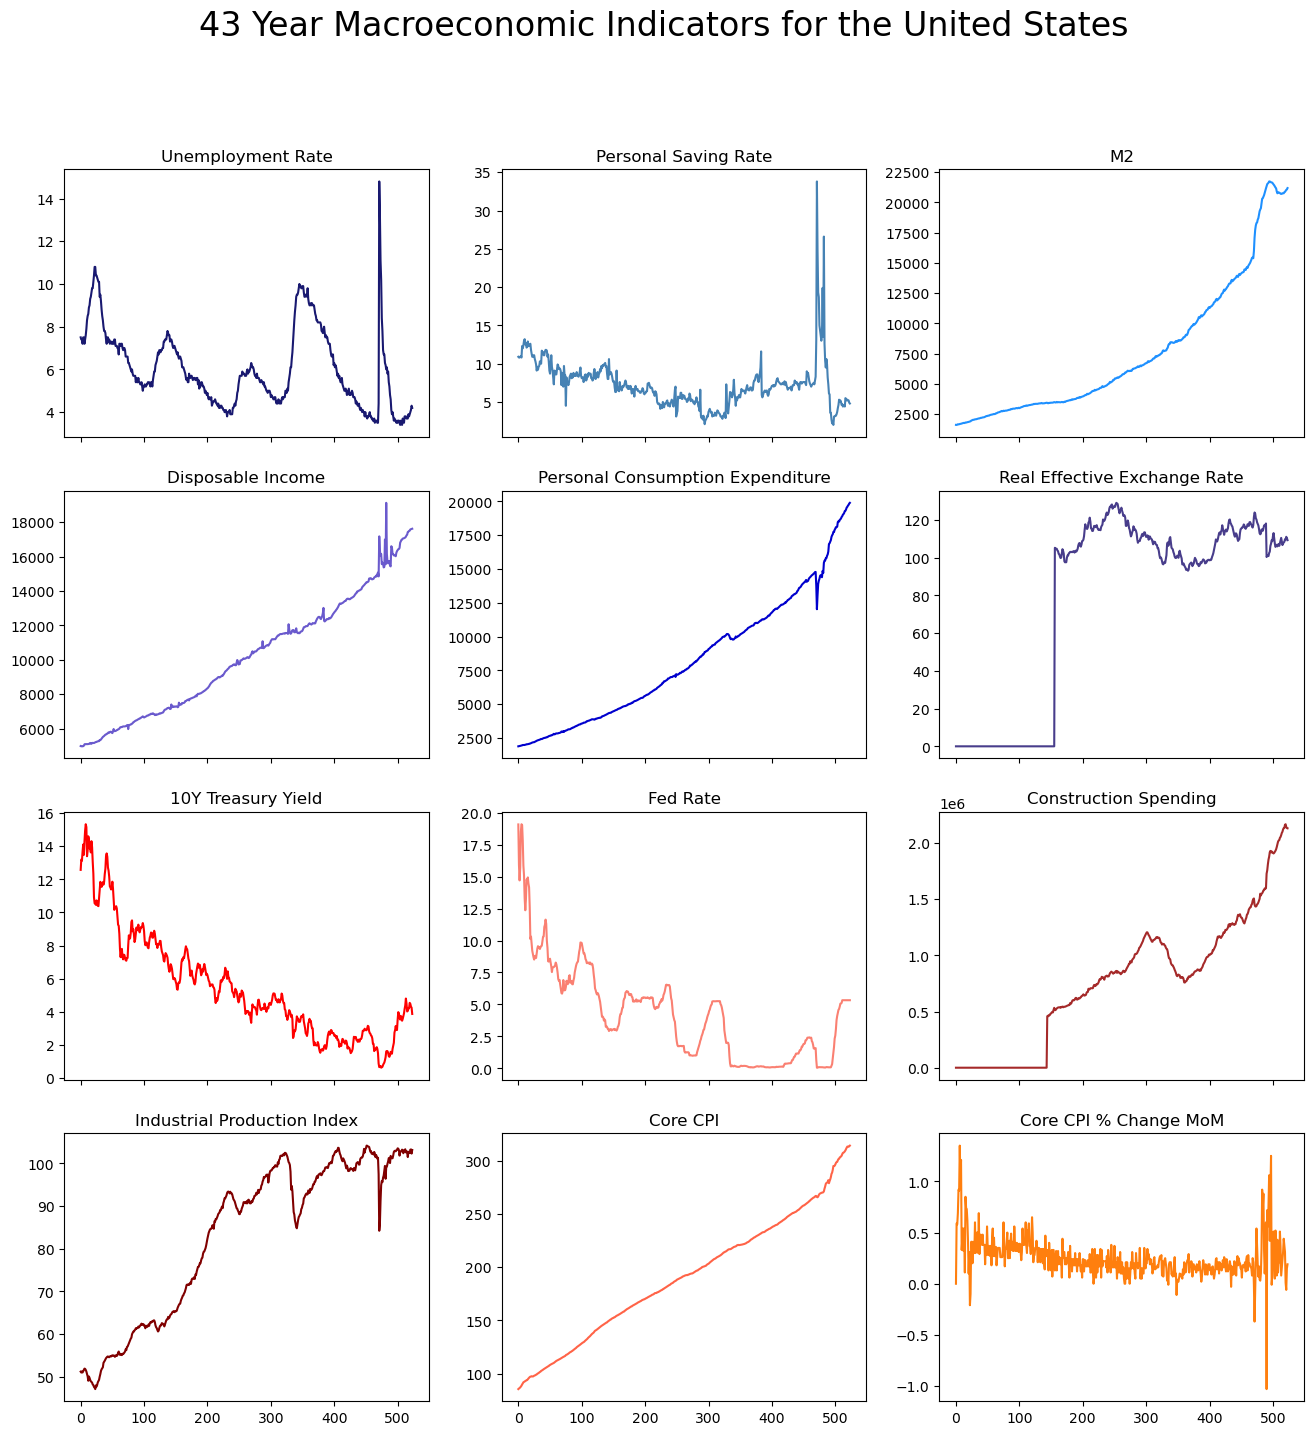

In [8]:
monthly_df['cpi_pct_mom'] = round((monthly_df['ccpi'].pct_change().fillna(0))*100,2)
monthly_df['cpi_pct_yoy'] = round((monthly_df['ccpi'].pct_change(12).fillna(0))*100,2)

monthly_df.iloc[:, 1:13].plot(kind ='line',
            subplots = True,
            figsize = (16,16),
            title = ['Unemployment Rate', 'Personal Saving Rate','M2','Disposable Income','Personal Consumption Expenditure','Real Effective Exchange Rate',
                     '10Y Treasury Yield','Fed Rate','Construction Spending','Industrial Production Index','Core CPI','Core CPI % Change MoM'],
            legend = False,
            layout = (4,3),
            sharex = True,
            style = ['midnightblue', 'steelblue', 'dodgerblue', 'slateblue','mediumblue','darkslateblue','red','salmon','brown','maroon','tomato'])

plt.suptitle('43 Year Macroeconomic Indicators for the United States', fontsize = 24)

### Core CPI trend by Month and Quarter
<a id = "mq"></a>

In [9]:
monthly_df['year'] = monthly_df['DATE'].apply(lambda x: x.year)
monthly_df['quarter'] = monthly_df['DATE'].apply(lambda x: x.quarter)
monthly_df['month'] = monthly_df['DATE'].apply(lambda x: x.month)

In [10]:
fig = px.box(monthly_df[12:], x="month", y="cpi_pct_yoy", points = "all", template = "presentation",)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',))

fig = px.box(monthly_df[12:], x="quarter", y="cpi_pct_yoy", points = "all", template = "presentation")

fig.show()

Yıllık bazda Çekirdek CPI değişimine baktığımızda, yılın erken dönemlerinde Çekirdek CPI'da daha belirgin artışlar olduğunu görebiliriz. Son birkaç ayda ise daha fazla aykırı değer (alt bıyıkların altında) var, yani bir önceki yıla göre çok az değişiklik gösterdiler.<br> Çekirdek CPI'daki değişimin oynaklığını daha fazla inceleyebiliriz.

In [11]:
fig = px.bar(
    data_frame=monthly_df.groupby(['month']).std().reset_index(), 
    x="month", 
    y="cpi_pct_yoy", text="cpi_pct_yoy"
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=13)
fig.show()

fig = px.bar(
    data_frame=monthly_df.groupby(['quarter']).std().reset_index(), 
    x="quarter", 
    y="cpi_pct_yoy", text="cpi_pct_yoy").update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=5)
fig.show()

## Forecasting Inflation

In [12]:
monthly_raw.shape
monthly_raw.head(20)

(524, 12)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,1981-01-01,7.5,10.9,1612.900,4980.4,1870.0,0.0,12.568571,19.084516,0.0,51.1668,85.4
1,1981-02-01,7.4,10.8,1608.125,4965.0,1884.2,0.0,13.194444,15.934286,0.0,50.9509,85.9
2,1981-03-01,7.4,10.8,1629.400,4979.0,1902.9,0.0,13.115909,14.703871,0.0,51.2066,86.4
3,1981-04-01,7.2,10.9,1665.575,4965.1,1904.4,0.0,13.679524,15.719000,0.0,50.9711,87.0
4,1981-05-01,7.5,11.0,1655.150,4974.8,1913.8,0.0,14.099500,18.517742,0.0,51.2645,87.8
5,1981-06-01,7.5,10.8,1664.500,5001.9,1934.5,0.0,13.472273,19.099667,0.0,51.5247,88.6
6,1981-07-01,7.2,12.3,1685.225,5080.8,1942.1,0.0,14.280909,19.035806,0.0,51.8727,89.8
7,1981-08-01,7.4,12.0,1693.280,5095.9,1966.6,0.0,14.937143,17.817742,0.0,51.8156,90.7
8,1981-09-01,7.6,12.4,1706.150,5087.2,1965.5,0.0,15.323810,15.874000,0.0,51.5692,91.8
9,1981-10-01,7.9,13.0,1725.450,5093.8,1963.9,0.0,15.148095,15.080000,0.0,51.1851,92.1


Tarihi veri çerçevesinin indeksi olarak ayarlama.

In [13]:
df_cpi = monthly_raw.set_index('DATE')

## ARIMA Uygulaması
<a id = "arima"></a>
Sorun bir zaman serisi tahmini olduğundan, AR ve MA modellerini birleştiren Otoregresif Entegre Hareketli Ortalama (ARIMA) gelecekteki eğilimleri/değerleri tahmin etmek için kullanılabilir.<br> ARIMA'nın bazı avantajları arasında yorumlanabilirliği, uygulama kolaylığı ve hatta gözlem sayısının daha sofistike modeller uygulamak için yeterli olmadığı bu durum gibi nispeten kısa seriler için daha iyi çalışması sayılabilir.<br> Öte yandan, ARIMA modellerinin bir sınırlaması sabit varyans varsayımıdır ve finansal zaman serilerinde çoğu veri oynaklık, asimetriler, düzensiz zaman aralıkları, ani salgınlar gösterir, bu nedenle bu model genellikle finansal zaman serisi verilerinde zayıf performans gösterir (Petrica ve diğerleri, 2016).

**Referanslar**:<br>
- <a src="https://www.datasciencecentral.com/profiles/blogs/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-ser"> ARIMA/SARIMA vs LSTM with Ensemble learning Insights for Time Series Data by Sharmistha Chatterjee
- Petrica ve diğerleri tarafından finansal ve parasal ekonomide ARIMA modellerinin sınırlandırılması, (2016)

### Zaman Serisi Ayrıştırma
Verileri trend, mevsimsel ve kalıntı bileşenlerine ayırın

<Axes: xlabel='DATE'>

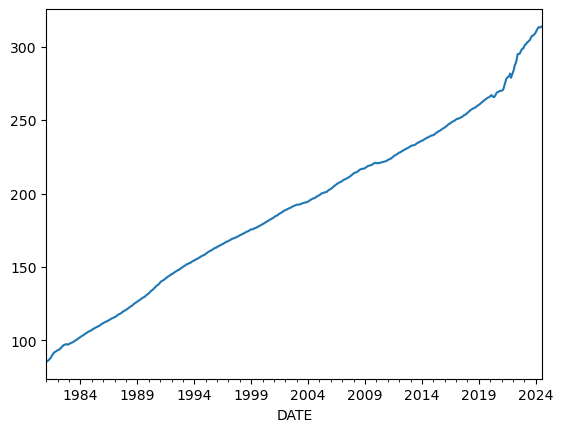

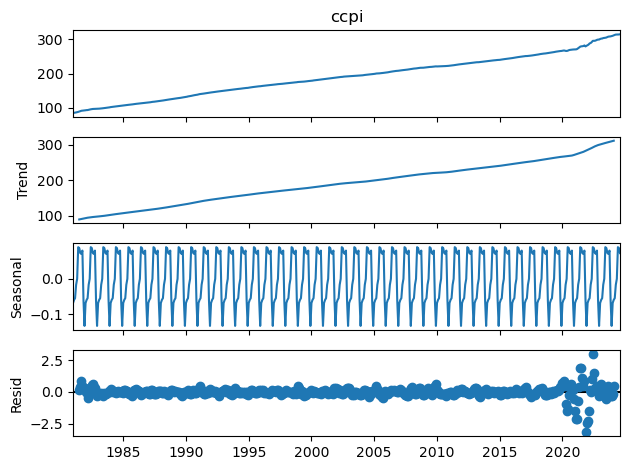

In [14]:
df_cpi['ccpi'].plot()
fig = seasonal_decompose(df_cpi['ccpi'], model='additive').plot()

Veriler belirgin bir yükseliş eğilimi gösteriyor ve durağan değil. ARIMA modelinin temel varsayımlarından biri zaman serisinin durağan olması olduğundan, durağan olmayan durumu daha sonra düzeltmemiz gerekiyor.

### Verileri Bölme
Veri kümesi küçük olduğundan, <b>örneklem dışı test veri kümesi olarak son 12 ayı</b> kullanacağız.

Training dataset: 476, Test dataset: 48


<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

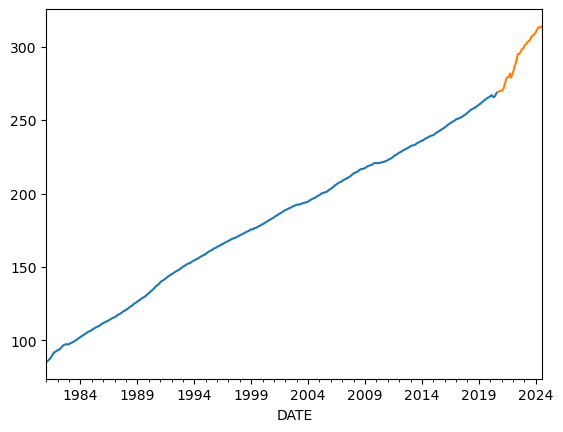

In [15]:
split_point = len(df_cpi) - 48
train, test = df_cpi[0:split_point], df_cpi[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['ccpi'].plot()
test['ccpi'].plot()

Grafikten, 2020'nin pandemi kısıtlamaları nedeniyle düşüş gösterdiğini görebiliyoruz. Turuncu çizgi Test setini gösteriyor.

### İlk farkları alın
Burada, zaman serisinin durağan olması için birim kökü kaldırmak için en uygun fark sayısını buluyoruz. Bu, diff() fonksiyonu kullanılarak ve Augmented Dickey-Fuller testi ile test edilerek yapılır.

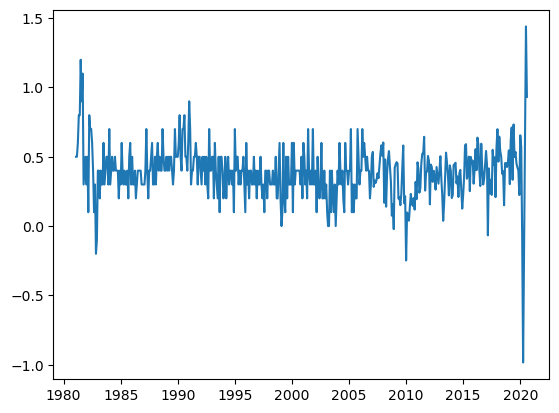

In [16]:
diff = train['ccpi'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

### Artırılmış Dickey–Fuller testi
Küçük p değeriyle, 1 fark alma, birim kökü kaldırmak ve seriyi durağan hale getirmek için yeterlidir.

In [17]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(diff)

Series is stationary


### ACF ve PACF'yi plot
Şimdi, acf ve pacf çizimini kullanarak optimum p ve q'yu bulmamız gerekiyor. Burada p gecikme sayısı ve q MA teriminin sırasıdır. <br><br>
Oto Regresif Terimin (p) sırasını bulma
- PACF gecikmesi 1 önemlidir

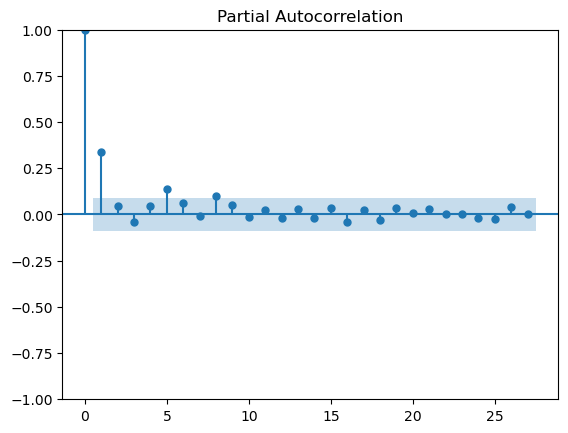

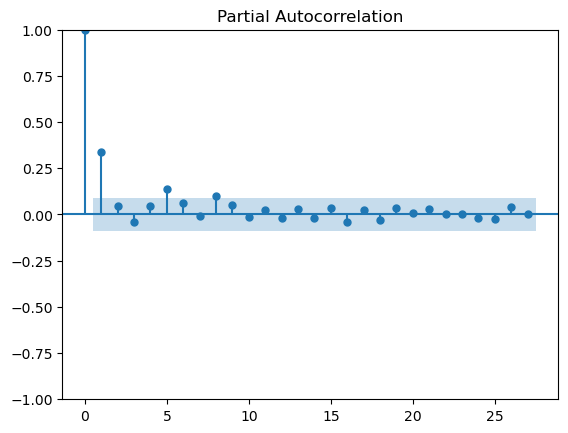

In [18]:
plot_pacf(diff.values)

Hareketli Ortalama Teriminin (q) sırasını bulma<br>
- q = 1 ve 2 önemlidir, q = 1 için muhafazakar bir yaklaşım deneyin.

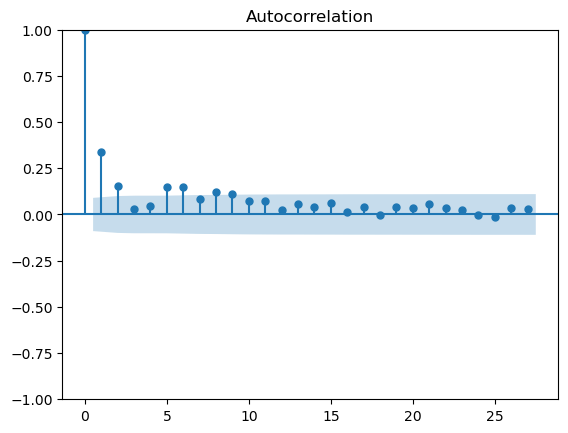

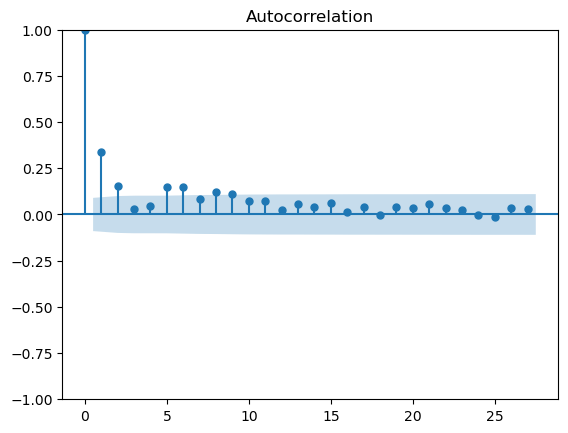

In [19]:
plot_acf(diff.values)

### Modelin oluşturulması
CPI üstel büyüme gösterdiğinden (varyans artar), modeli ln(CPI) üzerine kurarız, örneğin ham değerleri logaritmik değerlere dönüştürürüz.<br>
Daha önce keşfedildiği gibi, ARIMA model parametreleri 1,1,1 olarak ayarlanacaktır.

In [20]:
arima_model = ARIMA(np.log(train['ccpi']), order = (1,1,1))

arima_fit = arima_model.fit()
arima_fit.summary()

c:\Users\cetin\.conda\envs\mye\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cetin\.conda\envs\mye\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\cetin\.conda\envs\mye\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ccpi   No. Observations:                  476
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2510.391
Date:                Wed, 11 Dec 2024   AIC                          -5014.783
Time:                        21:03:42   BIC                          -5002.293
Sample:                    01-01-1981   HQIC                         -5009.871
                         - 08-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9739      0.006    158.577      0.000       0.962       0.986
ma.L1         -0.5176      0.027    -18.973      0.000      -0.571      -0.464
sigma2      1.493e-06   5.12e-08     29.129      0.000    1.39e-06    1.59e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):               644.93
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  Tahmini
Sonraki 12 ay için tahmin (örneklem dışı 12 ay)

The forecasted U.S. Core Consumer Price Index (CPI) YoY is  8.48


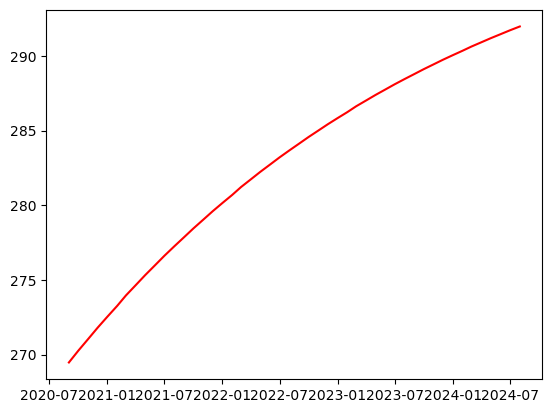

In [21]:
forecast = arima_fit.forecast(steps=48)
forecast = np.exp(forecast)

plt.plot(forecast, color = 'red')

pct_chg = ((forecast[-1] - df_cpi.iloc[-48]['ccpi'])/df_cpi.iloc[-48]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

### ARIMA modelinin değerlendirilmesi
- RMSE ve
- Gözlemlenen y'nin ortalaması - tahmin edilen y

Ortalama Hataya dayanarak, ARIMA modeli Çekirdek CPI değerini ortalama 0,25 oranında fazla tahmin eder.

In [22]:
mse = mean_squared_error(test['ccpi'].values, forecast[:48])
print('MSE: ', mse)
model_error = test['ccpi'] - forecast
print('Mean Model Error: ', model_error.mean())

MSE:  176.72198547373594
Mean Model Error:  10.214510573911673


### Eylül 2024 için 1 Adımlı Tahmin

In [ ]:
arima_model = ARIMA(np.log(test['ccpi']), order = (1,1,1),freq=test.index.inferred_freq)

arima_fit = arima_model.fit()

forecast = arima_fit.forecast(steps=1)
forecast = np.exp(forecast)

print('The Core CPI value for the month September 2024 predicted by ARIMA model is', round(forecast[0],2))

c:\Users\cetin\.conda\envs\mye\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



The Core CPI value for the month November 2021 predicted by ARIMA model is 314.62


Genel olarak, ARIMA'nın 2024'in sonraki aylarında daha büyük bir artış olması nedeniyle kötü performans gösterdiğini görebiliyoruz. Diğer özellikleri ekleyerek ve çok değişkenli tahmin kullanarak modeli iyileştirebiliriz.

## LSTM ile Tek Değişkenli Zaman Serisi Tahmini
<a id = "ulstm"></a>
Uzun Kısa Süreli Bellek (LSTM) Tekrarlayan Sinir Ağları, bilinmeyen süre gecikmeleri nedeniyle zaman serisi verilerine dayalı tahminler yapmakta popülerdir. LSTM, daha uzun zaman adımlarını hatırlamak için birden fazla anahtar kapısıyla kaybolan eğim sorununu ele alır. Bu nedenle modele gelen geçmiş girdiler bir ayak izi bırakır. LSTM'lerde, Hhidden Markov modelinde gerekli olduğu gibi önceden sonlu sayıda durum tutmaya gerek yoktur. LSTM'nin yaygın sınırlamaları (risk), aşırı uyum sağlamanın kolay olması ve bu modelleri hızlı bir şekilde eğitmek için çok fazla kaynak (hesaplama gücü) gerektirmesi ve bellek bant genişliğine bağlı hesaplama gerektirmesi anlamında eğitilmesinin zor olmasıdır.

Sorun Ocak 2021'in Çekirdek CPI değerini tahmin etmeyi gerektirdiğinden, 12 giriş zaman adımını kullanarak tek adımlı bir tahmini tahmin etmek için LSTM'yi kullanabiliriz.

LSTM mimarisi, varsayılan aktivasyon tanh'ına sahip bir gizli katmana sahip basit, sade bir LSTM olacaktır.

**Referanslar**:<br>
[RNN / LSTM'nin düşüşü](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0) Eugenio Culurciello tarafından <br>
[Derin Öğrenmenin Temelleri: Uzun Kısa Süreli Belleğe Giriş](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

### Ölçekleme ve Veri Hazırlama
- Min-Maks Normalizasyonu ile Ölçekleme
- Tek değişkenli diziyi 12 adım içeri 1 adım dışarı olacak şekilde örneklere bölme

**Referanslar**<br>
Bölünmüş dizi kodu, [buradan](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/) erişilebilen Machine Learning Mastery koduna dayanmaktadır.

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
ccpi = monthly_raw['ccpi'].values
dataset = scaler.fit_transform(ccpi.reshape(-1,1))
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


Yukarıda görüldüğü gibi 12 zaman adımlı ve 1 çıktı içeren bir veri yapısı oluşturuyoruz.

In [25]:
n_steps_in = 12

train, test = dataset[0:476], dataset[476:len(dataset),:]

trainX, trainY = split_sequence(train, n_steps_in)
testX, testY = split_sequence(test, n_steps_in)

### Modeli Eğitme

Tek katmanlı, bırakma düzenlemesi olmayan ve Erken Durdurma olmayan bir vanilya modeli oluşturun. Kullanılacak nöron sayısı, yüksek boyutluluk için 100'dür (böylece model eğilimleri yakalayabilir). Çoğu parametre ince ayar ve deneme-yanılma yaklaşımıyla seçilir.

Katman sayısı, 1, sorunun karmaşıklığı nedeniyle seçilir. <br>Yapılan sinir ağının basit karmaşıklık yapısı (sadece 1 katman vardır ve bırakma eklemek önemli bilgilerin kaybolmasına neden olur) ve veri kümesi boyutu nedeniyle bırakma düzenlemesi yoktur. LSTM için optimum düzeylerde 0.1/0.2 bırakma düzenlemesi denendi ve test kümesindeki tahmin performansını önemli ölçüde azalttı. Bırakma, özellikle sınırlı zaman adımları ve 1 katman içeren bu sorunda önemli bağlam bilgilerini siler. Ayrıca, tren kaybı ve doğrulama kaybı aşırı uyum açısından dikkatlice izlenir.<br>
Benzer şekilde, sinir ağının boyutu ve küçük veri boyutu nedeniyle 0,001'lik küçük bir öğrenme oranı kullanılır.

Toplu boyut 100 dönem olarak ayarlanır. Toplu boyut ince ayarı, modelin performansının gözlemlenmesine dayanarak yapılır.

<function matplotlib.pyplot.show(close=None, block=None)>

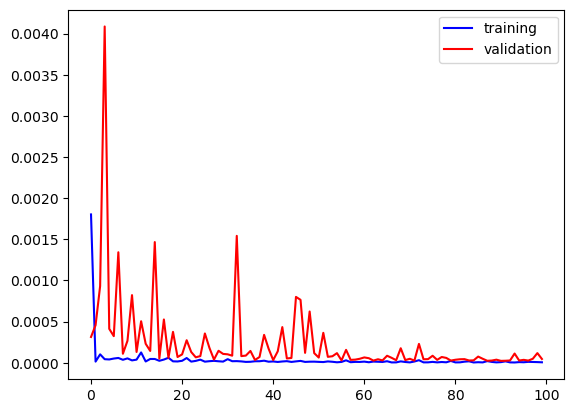

In [26]:
n_features = trainX.shape[2]

uni_model = Sequential()

# Adding the LSTM layer
uni_model.add(LSTM(64, input_shape=(trainX.shape[1], n_features)))

# Adding the output layer
uni_model.add(Dense(1))

uni_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error', metrics=['mean_absolute_error'])

fit = uni_model.fit(trainX, 
          trainY, validation_data = (testX, testY),   
          epochs = 100, batch_size=1,
          verbose = 0)


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show

Hafif bir aşırı uyum görebiliriz.

**Not**: Doğrulama kaybı, geçirilen küçük batch_size nedeniyle önemli artış ve dalgalanmalar gösteriyor.

### Test Setinde Tahminler
- Hem eğitim setinde hem de test setinde tahminler yapın
- Normalleştirilmişten orijinal değere ters dönüşüm yapın.

In [27]:
trainPredict = uni_model.predict(trainX)
testPredict = uni_model.predict(testX)

Ytrain_hat = scaler.inverse_transform(trainPredict)
Ytrain_actual = scaler.inverse_transform(trainY)
Ytest_hat = scaler.inverse_transform(testPredict)
Ytest_actual = scaler.inverse_transform(testY)

2/2 [==============================] - 0s 4ms/step


### Tek değişkenli LSTM'yi değerlendirme

ARIMA'ya benzer şekilde, modelin tahmin gücünü değerlendirmek için MSE ve Ortalama Model Hatası'nı kullanacağız.

In [28]:
trainScore = mean_squared_error(Ytrain_actual, Ytrain_hat[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(Ytest_actual, Ytest_hat[:,0])
print('Test Score: %.2f MSE' % (testScore))

model_error = Ytest_actual - Ytest_hat[:,0]
print('Mean Model Error: ', model_error.mean())

Train Score: 4935.38 MSE
Test Score: 241.27 MSE
Mean Model Error:  -1.0708761935763904


Bu model, 1.70 MSE ve 0.78 Ortalama Model Hatası ile ARIMA modeline kıyasla önemli bir gelişme gösterdi; bu da modelin hafif bir düşük tahmin verdiğini gösteriyor. MSE'ye göre, modelin ortalama hatası sqrt(1.70) = 1.30'dur.

<Axes: title={'center': 'Actual'}, xlabel='DATE'>

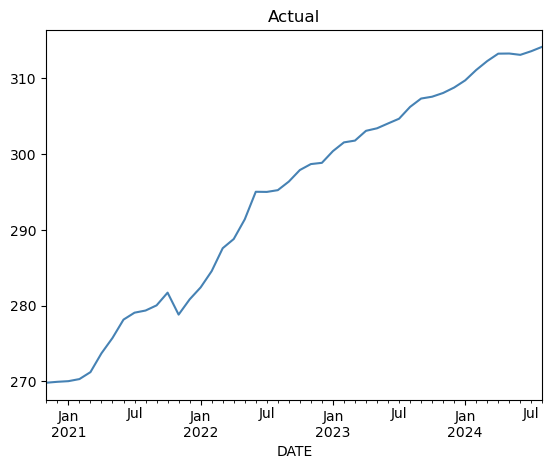

<Axes: title={'center': 'Forecasted'}>

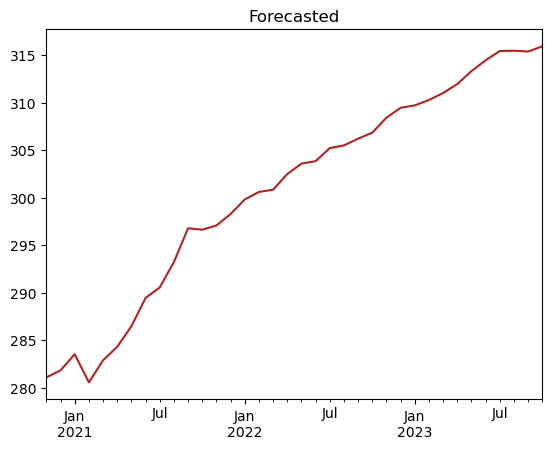

In [29]:
observed = df_cpi.loc['2020-11-01':'2024-08-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(Ytest_hat, index=pd.date_range('2020-11-01',periods=len(Ytest_hat),freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

Yukarıdaki çizgi grafiğinden, tek değişkenli LSTM'nin Çekirdek CPI'nin şeklini "yaklaşık olarak" tahmin edebildiğini (geri kalmış olsa da) ve değeri hafife aldığını görebiliriz.

### Eylül 2024 için Tahmin

Modele son 12 gözlemi (12 adım içeri) girdik ve böylece Kasım 2021 ayı için Çekirdek CPI değeri olacak 1 adım dışarıyı tahmin etti.

Ardından, yıllık yüzdelik değişimi manuel olarak hesapladık.

In [31]:
x_input = np.array(dataset[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = uni_model.predict(x_input)

forecast = scaler.inverse_transform(forecast_normalized)
print('The Core CPI value for the month Sep 2024 predicted by LSTM is ', forecast[0][0])

pct_chg = ((forecast[0][0] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))


1/1 [==============================] - 0s 18ms/step
The Core CPI value for the month Sep 2024 predicted by LSTM is  316.49548
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  3.0


## LSTM'lerle Çok Değişkenli Zaman Serisi Tahmini
<a id = "mlstm"></a>
### Veri Hazırlama
- Granger Nedensellik Testi ile Özellik Seçimi
- Min-Maks normalizasyonu ile Ölçekleme
- Çok değişkenli diziyi 12 adımlı ve 1 adımlı örneklere bölme (<i>Kod machinelearningmastery'den referans alınmıştır</i>)

#### Özellik Seçimi
Çekirdek CPI'yi tahmin etmek için hangi özelliklerin yararlı olduğunu görmek için Granger Nedensellik testini kullanacağız.
Bu testi kullanmadan önceki temel varsayımlardan biri, verilerin durağan olmasını gerektirir. Bu nedenle, her özellik için ilk farkları alır ve durağanlığı kontrol etmek için aynı ADF test fonksiyonunu kullanırız.

In [32]:
monthly_df_stationary = df_cpi.diff().dropna()
monthly_df_stationary = monthly_df_stationary.rename_axis('indicator', axis=1)
fig = px.line(monthly_df_stationary.iloc[:,0:10], facet_col="indicator", facet_col_wrap=1) 
fig.update_yaxes(visible=False)

In [33]:
for indi in monthly_df_stationary:
    print('ADF Test: ', indi)
    adf_test(monthly_df_stationary[[indi]])
    
monthly_df_stationary[['m2']] = monthly_df_stationary[['m2']].diff().dropna()
monthly_df_stationary[['tcs']] = monthly_df_stationary[['tcs']].diff().dropna()
monthly_df_stationary[['ccpi']] = monthly_df_stationary[['ccpi']].diff().dropna()

ADF Test:  unrate
Series is stationary
ADF Test:  psr
Series is stationary
ADF Test:  m2
Series is stationary
ADF Test:  dspic
Series is stationary
ADF Test:  pce
Series is stationary
ADF Test:  reer
Series is stationary
ADF Test:  ir
Series is stationary
ADF Test:  ffer
Series is stationary
ADF Test:  tcs
Series is stationary
ADF Test:  indpro
Series is stationary
ADF Test:  ccpi
Series is stationary


İlk fark alma işleminden sonra M2, TCS ve CCPI hala durağan olmadığından bu göstergeler için ikinci fark alma işlemini yaparak hala birim kök içerip içermediğine bakacağız.

In [34]:
# Drop any NaNs first
monthly_df_stationary = monthly_df_stationary.dropna()

for indi in monthly_df_stationary:
    print('ADF Test: ', indi)
    adf_test(monthly_df_stationary[[indi]])

ADF Test:  unrate
Series is stationary
ADF Test:  psr
Series is stationary
ADF Test:  m2
Series is stationary
ADF Test:  dspic
Series is stationary
ADF Test:  pce
Series is stationary
ADF Test:  reer
Series is stationary
ADF Test:  ir
Series is stationary
ADF Test:  ffer
Series is stationary
ADF Test:  tcs
Series is stationary
ADF Test:  indpro
Series is stationary
ADF Test:  ccpi
Series is stationary


M2, TCS ve CCPI artık ikinci fark alma işleminden sonra durağandır. Özelliklerimiz ile Çekirdek CPI arasındaki nedenselliği araştırmak için Grangers Nedensellik Testi'ni kullanmaya devam edebiliriz. Granger nedenselliği, tahmine dayalı ve finansal ekonomide oldukça önemli olan istatistiksel bir nedensellik kavramıdır.

Aşağıdaki kod [stackoverflow](https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with) adresinden alınmıştır.

In [35]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(monthly_df_stationary, variables = monthly_df_stationary.columns)

,unrate_x,psr_x,m2_x,dspic_x,pce_x,reer_x,ir_x,ffer_x,tcs_x,indpro_x,ccpi_x
unrate_y,1.0000,0.0003,0.0000,0.0366,0.0000,0.3529,0.0056,0.0000,0.5031,0.0000,0.1640
psr_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.8663,0.3736,0.0199,0.1560,0.0000,0.0014
m2_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.7159,0.1494,0.0107,0.3594,0.0000,0.0003
dspic_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.6574,0.4998,0.2258,0.2423,0.0000,0.0000
pce_y,0.0000,0.0005,0.0000,0.0000,1.0000,0.6680,0.0601,0.0925,0.3442,0.0000,0.5171
reer_y,0.8604,0.0489,0.9760,0.3586,0.5916,1.0000,0.5981,0.8349,0.0000,0.6422,0.4962
ir_y,0.5169,0.2876,0.3275,0.6565,0.3615,0.3764,1.0000,0.0000,0.6092,0.6708,0.0449
ffer_y,0.6918,0.7045,0.8888,0.7616,0.7998,0.3156,0.0000,1.0000,0.5779,0.4490,0.1008
tcs_y,0.6368,0.3631,0.2578,0.0256,0.0434,0.5546,0.4876,0.7903,1.0000,0.3407,0.1963
indpro_y,0.0000,0.0000,0.0000,0.0014,0.0000,0.3535,0.0001,0.0003,0.6503,1.0000,0.0844


Burada, sadece **son satıra** odaklanabiliriz ve daha önceki gibi 0,05'lik bir anlamlılık düzeyi kullanacağız, dolayısıyla 0,05'ten küçük olan tüm p değerleri için sıfır hipotezini reddedebilir ve özellik granger'ının Temel TÜFE'ye neden olduğu sonucuna varabiliriz.<br><br> Gerçek Efektif Döviz Kuru, 10 Yıllık Hazine Getirisi ve Fed Faiz Oranı anlamlı değildir, dolayısıyla öncelikle bunları gelecekteki modellerimizden hariç tutarak veri çerçevesinden çıkarabiliriz.

In [36]:
feat_df = df_cpi.drop(['reer', 'ir','ffer'], axis = 1)

#### Min-Maks Normalizasyonu ile Ölçekleme

In [37]:
scaled = scaler.fit_transform(feat_df)

Yeniden kullanılabilirlik amaçları için diziyi veri çerçevesine geri dönüştürün

In [38]:
scaled_df = pd.DataFrame(scaled, columns=feat_df.columns, index=feat_df.index)
scaled_df.head(5)

,unrate,psr,m2,dspic,pce,tcs,indpro,ccpi
DATE,,,,,,,,
1981-01-01,0.359649,0.279874,0.000237,0.001088,0.000000,0.0,0.071733,0.000000
1981-02-01,0.350877,0.276730,0.000000,0.000000,0.000788,0.0,0.067952,0.002186
1981-03-01,0.350877,0.276730,0.001058,0.000989,0.001825,0.0,0.072431,0.004372
1981-04-01,0.333333,0.279874,0.002856,0.000007,0.001908,0.0,0.068306,0.006995
1981-05-01,0.359649,0.283019,0.002338,0.000692,0.002430,0.0,0.073445,0.010493


#### Çok Değişkenli Dizileri Örneklere Bölme

In [39]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()    
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        
        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        
        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Tek değişkenli modele benzer şekilde, son 12 ayı test kümesi olarak bırakacağız. Girişleri, eğitim kümesi için 1994'ten 2019'a (2000'in ilk 12 zaman adımını içereceği) ve test kümesi için 2019'dan 2020'ye (2019'un ilk 12 adımı içereceği) olacak şekilde yapılandırıyoruz.

In [41]:
# Eğitim verileri (1981-01-01 - 2020-11-01)
in_cpi = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['ccpi']]) 
in_ur = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['unrate']])
in_m2  = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['m2']])
in_pce = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['pce']])
in_dspic  = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['dspic']])
in_tcs = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['tcs']])
in_psr = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['psr']])
in_ind = np.array(scaled_df.loc['1981-01-01':'2020-11-01', ['indpro']])

# Test verileri (2020-11-01 - 2024-08-01, toplam 48 veri)
test_cpi = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['ccpi']]) 
test_ur = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['unrate']])
test_pce = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['pce']])
test_dspic  = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['dspic']])
test_m2  = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['m2']])
test_tcs = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['tcs']])
test_psr = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['psr']])
test_ind = np.array(scaled_df.loc['2020-11-01':'2024-08-01', ['indpro']])

# Output verileri
trainoutput_cpi = in_cpi
testoutput_cpi = test_cpi


Daha sonra giriş ve çıkış verilerini satır, sütun formatına yeniden şekillendiriyoruz.

In [42]:
in_cpi = in_cpi.reshape((len(in_cpi), 1))
in_ur = in_ur.reshape((len(in_ur), 1))
in_pce = in_pce.reshape((len(in_pce), 1))
in_dspic = in_dspic.reshape((len(in_dspic), 1))
in_m2  = in_m2.reshape((len(in_m2), 1))
in_tcs = in_tcs.reshape((len(in_tcs), 1))
in_psr = in_psr.reshape((len(in_psr), 1))
in_ind = in_ind.reshape((len(in_ind), 1))

test_cpi = test_cpi.reshape((len(test_cpi), 1))
test_ur = test_ur.reshape((len(test_ur), 1))
test_pce = test_pce.reshape((len(test_pce), 1))
test_dspic = test_dspic.reshape((len(test_dspic), 1))
test_m2  = test_m2.reshape((len(test_m2), 1))
test_tcs = test_tcs.reshape((len(test_tcs), 1))
test_psr = test_psr.reshape((len(test_psr), 1))
test_ind = test_ind.reshape((len(test_ind), 1))

trainoutput_cpi = trainoutput_cpi.reshape((len(trainoutput_cpi), 1))
testoutput_cpi = testoutput_cpi.reshape((len(testoutput_cpi), 1))

Şimdi, numpy hstack kullanarak tüm sütunları yatay olarak istifliyoruz ve onu split sequences fonksiyonuna geçirilmeye hazır hale getiriyoruz. Ve tanımlanmış adımları ve tek adımlı tahmini geçiriyoruz.

In [43]:
trainset = np.hstack((in_cpi, in_ur, in_pce, in_dspic, in_m2, in_tcs, in_psr, in_ind, trainoutput_cpi))
testset = np.hstack((test_cpi, test_ur, test_pce, test_dspic, test_m2, test_tcs, test_psr, test_ind, testoutput_cpi))

n_steps_in = 12
n_steps_out = 1

trainX, trainy = split_sequences(trainset, n_steps_in, n_steps_out)

testX, testy = split_sequences(testset, n_steps_in, n_steps_out)

trainX.shape, trainy.shape

((468, 12, 8), (468, 1))

### Modelin Eğitimi
İlk model, tek değişkenli modelle benzer parametrelere sahip bu çok değişkenli modelde denendi ancak düşük performansla sonuçlandı. Model, varsayılan 32 toplu boyutu ve ek bir LSTM katmanının istiflenmesiyle 500 döneme daha fazla ayarlandı. En uygun dönemleri ve toplu boyutu bulmak için daha önce bir GridSearchCV denemesi yapıldı.

Model önemli ölçüde aşırı uyum gösterdi, bu nedenle EarlyStopping ve Dropout ile düzenleme kullanıldı. Son Dropout %20 olarak ayarlandı ve rec ile Dense tam çıktı katmanı arasına eklendi. EarlyStopping sabrı 50 olarak ayarlandı.

Hiperparametreler ayrıca performansı gözlemleyen manuel deneysel çalışmalarla ayarlandı.

**Referanslar**:<br>
<li><a src="https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize/58868383#58868383"> RNN Düzenlemesine kapsamlı bir cevap

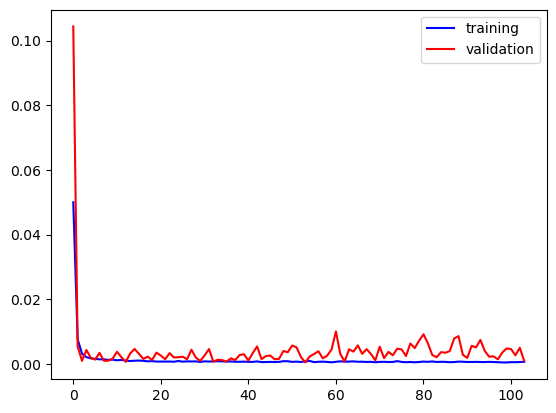

In [44]:
n_features = trainX.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(n_steps_in, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(n_steps_out))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                  mode = 'min',
                  verbose = 0)

fit = multi_model.fit(trainX, 
          trainy, validation_data = (testX, testy),   
          epochs = 500, verbose=0, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

**Not**: Model 170. döneme yakın bir zamanda erken durduruldu.

### Özellik Önemi

Tekrarlayan sinir ağını etkileyen özellik önemini niceliksel olarak belirlemenin ve tanımlamanın birkaç yolu vardır. Bunlardan bazıları Pertubasyonlar, [Masking](https://stackoverflow.com/questions/44119207/is-there-any-way-to-get-variable-importance-with-keras)/[LIME](https://arxiv.org/abs/1606.05386), [Permutation Importance](https://www.kaggle.com/cdeotte/lstm-feature-importance) ve [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)'dir (ancak bu, benim tarafımda tensorflow 2.7.0 ile birçok uyumluluk sorununa yol açtı).

Burada, Masking ve LIME'a oldukça benzeyen pertubasyon etkisini kullanacağız. Buradaki fikir, gürültüyü tanıtmayı/her değişkeni rastgele normal dağılımla bozmayı ve ardından bozulmuş tahmin edilen y ile orijinal tahmin edilen y arasındaki farkı hesaplamayı içerir.

**Referanslar**<br>
Sinir Ağları'ndaki bozulma hakkında daha fazla bilgi [burada](https://towardsdatascience.com/perturbation-theory-in-deep-neural-network-dnn-training-adb4c20cab1b) ve [burada](https://stats.stackexchange.com/questions/191855/variable-importance-in-rnn-or-lstm) bulunabilir.

In [45]:
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False) # Randomly generate 100 numbers arange(218) 
    x = g[random_ind] #  Take 100 random sample from training set
    orig_out = model.predict(x)
    for i in range(8):  # iterate over the 7 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')
        
feature_importance(multi_model,trainX)

4/4 [==============================] - 0s 5ms/step
Variable 1, Perturbation Effect: 0.141
4/4 [==============================] - 0s 4ms/step
Variable 2, Perturbation Effect: 0.007
4/4 [==============================] - 0s 5ms/step
Variable 3, Perturbation Effect: 0.062
4/4 [==============================] - 0s 4ms/step
Variable 4, Perturbation Effect: 0.027
4/4 [==============================] - 0s 5ms/step
Variable 5, Perturbation Effect: 0.038
4/4 [==============================] - 0s 5ms/step
Variable 6, Perturbation Effect: 0.013
4/4 [==============================] - 0s 4ms/step
Variable 7, Perturbation Effect: 0.018
4/4 [==============================] - 0s 5ms/step
Variable 8, Perturbation Effect: 0.014


Bozulma etkisi sonuçlarıyla, bu model/veri setinde Çekirdek CPI'yi tahmin etmek için önemli özelliklerin geçmiş **Çekirdek CPI**, **Kişisel Tüketim Harcaması** ve **M2** olduğunu söyleyebiliriz. Kişisel Tüketim en önemli özelliklerden biridir ve bu açıktır çünkü PCE enflasyonu belirlemede önemli bir ölçüttür, bu nedenle Çekirdek CPI ile yakından ilişkili olmalıdır.

### Test Setinde Tahminler

Tahmin sonrasında, min-max normalizasyonunu tersine çevirmemiz gerekir. Bunu yapmak için, verileri normalizasyondan önceki orijinal forma geri şekillendiririz.
- testX'i yeniden şekillendirin ve doğru konumlarda y-hat (tahmin) ile birleştirin
- testX'i yeniden şekillendirin ve doğru konumlarda gerçek y ile birleştirin

Orijinal veri çerçevesinin sırasını eşleştirmek için, unemployment_rate, m2, pce, dspic, ffr, psr ve cpi sırasına göre birleştiririz.

In [46]:
testPredict = multi_model.predict(testX)

2/2 [==============================] - 0s 5ms/step


In [47]:
testX = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))

In [48]:
# Invert scaling for Predicted
testY_hat = np.concatenate((testX[:, 1:8], testPredict), axis=1)
testY_hat = scaler.inverse_transform(testY_hat)

testY_hat = testY_hat[:,7]

# Invert scaling for Actual
testY_actual = np.concatenate((testX[:,1:8], testy), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,7]

### Çok değişkenli LSTM'yi değerlendirme

Önceki modellere benzer şekilde, aynı metrikleri kullanacağız: MSE ve Ortalama Model Hatası.

In [49]:
mse = mean_squared_error(testY_actual, testY_hat)
print('Test MSE: %.3f' % mse)

model_error = testY_actual - testY_hat
print('Mean Model Error: ', model_error.mean())

Test MSE: 49.189
Mean Model Error:  4.073112428014628


In [50]:
print(testY_hat.shape)

(35,)


<Axes: title={'center': 'Actual'}, xlabel='DATE'>

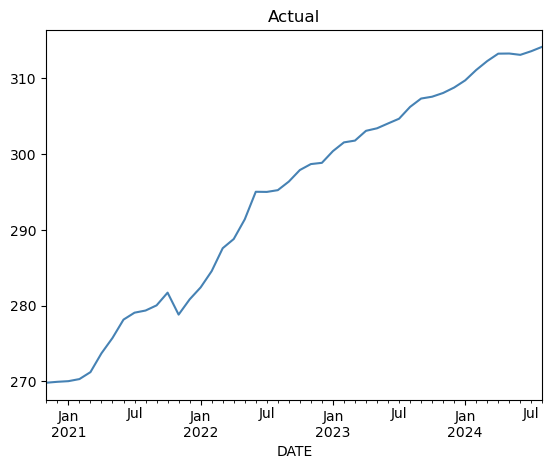

<Axes: title={'center': 'Forecasted'}>

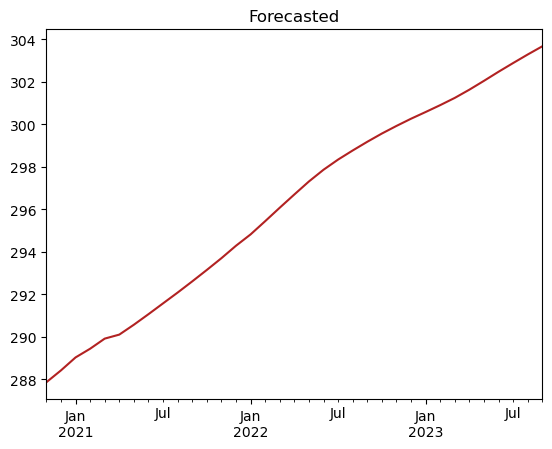

In [51]:
observed = df_cpi.loc['2020-11-01':'2024-08-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(testY_hat, index=pd.date_range('2020-11-01',periods=35,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

Tek değişkenli LSTM ile karşılaştırıldığında, model Ocak ayında kötü bir başlangıç ​​yaptı ve 2021'deki Çekirdek TÜFE'nin gerçek şeklini 'yaklaşık olarak' tahmin edemedi.

### Eylül 2024 Tahmini

In [52]:
x_input = np.array(scaled[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = multi_model.predict(x_input)
# Manually inverse Min-max normalization
max_cpi = df_cpi['ccpi'].max()
min_cpi = df_cpi['ccpi'].min()
forecast =  max_cpi-forecast_normalized[0][0]/(max_cpi-min_cpi)
print('The Core CPI value for the month Sep 2024 predicted by LSTM is ', forecast)

pct_chg = ((forecast - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

1/1 [==============================] - 0s 19ms/step
The Core CPI value for the month Sep 2024 predicted by LSTM is  314.1180482862387
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  2.22
